# Kaggle team name: **21049644**
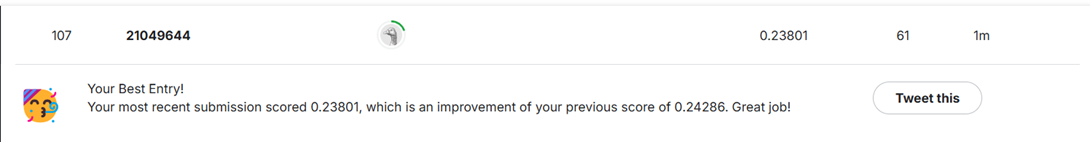

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import count as spark_count
from pyspark.sql.functions import col, when
from sklearn.preprocessing import StandardScaler
import builtins  # to access the built-in Python sum
import pandas as pd
from sklearn.model_selection import train_test_split

!curl -LJO https://raw.githubusercontent.com/qilinli/COMP3010-Machine-Learning/refs/heads/master/2025-assignment/train.csv
!curl -LJO https://raw.githubusercontent.com/qilinli/COMP3010-Machine-Learning/refs/heads/master/2025-assignment/test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1186k  100 1186k    0     0  4931k      0 --:--:-- --:--:-- --:--:-- 4944k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  328k  100  328k    0     0  2526k      0 --:--:-- --:--:-- --:--:-- 2548k


# **Section 3.1: Data Cleaning**

**Data Cleaning:** Processing and cleaning data from train.csv using Apache Spark

## **3.1.1:** Loading Data into Spark Dataframe


In [ ]:
spark = SparkSession.builder.appName("PressurePrediction").getOrCreate()
train_df = spark.read.csv("train.csv", header=True, inferSchema=True)
train_df.printSchema()
train_df.show(5)
train_df.count()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Tank Failure Pressure (bar): double (nullable = true)
 |-- Liquid Ratio: double (nullable = true)
 |-- Tank Width (m): double (nullable = true)
 |-- Tank Length (m): double (nullable = true)
 |-- Tank Height (m): double (nullable = true)
 |-- BLEVE Height (m): double (nullable = true)
 |-- Vapour Height (m): double (nullable = true)
 |-- Vapour Temperature (K): double (nullable = true)
 |-- Liquid Temperature (K): double (nullable = true)
 |-- Obstacle Distance to BLEVE (m): integer (nullable = true)
 |-- Obstacle Width (m): integer (nullable = true)
 |-- Obstacle Height (m): integer (nullable = true)
 |-- Obstacle Thickness (m): double (nullable = true)
 |-- Obstacle Angle: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Liquid Critical Pressure (bar): double (nullable = true)
 |-- Liquid Boiling Temperature (K): integer (nullable = true)
 |-- Liquid Critical Temperature (K): double (nullable = true)
 |-- Sensor

10050

## **3.1.2:** Handling NULL Values

In [ ]:
from pyspark.sql.functions import col, when
import builtins  # to access the built-in Python sum

# columns to check
cols_to_check = [
    "Tank Failure Pressure (bar)", "Liquid Ratio", "Tank Width (m)", "Tank Length (m)",
    "Tank Height (m)", "BLEVE Height (m)", "Vapour Height (m)", "Vapour Temperature (K)",
    "Liquid Temperature (K)", "Obstacle Distance to BLEVE (m)", "Obstacle Width (m)",
    "Obstacle Height (m)", "Obstacle Thickness (m)", "Obstacle Angle", "Status",
    "Liquid Critical Pressure (bar)", "Liquid Boiling Temperature (K)", "Liquid Critical Temperature (K)",
    "Sensor ID", "Sensor Position Side", "Sensor Position x", "Sensor Position y",
    "Sensor Position z", "Target Pressure (bar)"
]

# Count NULLs per row
null_expr = builtins.sum([when(col(c).isNull(), 1).otherwise(0) for c in cols_to_check])

train_df = train_df.withColumn("null_count", null_expr)

#Count rows with more than 7 NULLs
nulls_df = train_df.filter(col("null_count") > 7)
print("Rows with more than 10 NULLs:", nulls_df.count())

# Drop
train_df = train_df.filter(col("null_count") <= 7).drop("null_count")

print("Remaining rows:", train_df.count())

Rows with more than 10 NULLs: 10
Remaining rows: 10040


## **3.1.3:** Handling Outliers

In [ ]:
columns_to_check = [
    "Target Pressure (bar)",
    "Tank Failure Pressure (bar)",
    "Vapour Temperature (K)",
    "Liquid Temperature (K)", "Obstacle Distance to BLEVE (m)",  "Obstacle Angle", "Liquid Critical Pressure (bar)",
    "Liquid Boiling Temperature (K)", "Liquid Critical Temperature (K)"
]
for column in columns_to_check:
    q1, q3 = train_df.approxQuantile(column, [0.25, 0.75], 0.0001)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Identify outliers
    outliers = train_df.filter((col(column) < lower) | (col(column) > upper))
    count = outliers.count()
    print(f"Outliers in '{column}': {count}")

    # Display a few outliers
    if count > 0:
        outliers.select(column).show(10)

    # Remove outliers from DataFrame
    train_df = train_df.filter((col(column) >= lower) & (col(column) <= upper))
train_df.count()

Outliers in 'Target Pressure (bar)': 910
+---------------------+
|Target Pressure (bar)|
+---------------------+
|            1.0938188|
|            1.0914841|
|            1.0367405|
|            1.2049105|
|            1.1797085|
|            1.0826703|
|            1.2020811|
|            1.1869165|
|            1.0878665|
|           0.98808491|
+---------------------+
only showing top 10 rows

Outliers in 'Tank Failure Pressure (bar)': 45
+---------------------------+
|Tank Failure Pressure (bar)|
+---------------------------+
|                1722.348566|
|                2379.656661|
|                2717.264817|
|                3209.891707|
|                2911.509527|
|                1080.803316|
|                4157.535006|
|                3681.690849|
|                4578.906769|
|                3165.535756|
+---------------------------+
only showing top 10 rows

Outliers in 'Vapour Temperature (K)': 0
Outliers in 'Liquid Temperature (K)': 0
Outliers in 'Obstacle Dis

8993

## **3.1.4:** Feature Engineering

In [ ]:
from pyspark.sql.functions import round as spark_round
train_df = train_df.withColumn(
    "Tank Volume (m^3)", spark_round(col("Tank Width (m)") * col("Tank Length (m)") * col("Tank Height (m)"), 2))

train_df = train_df.withColumn(
    "Obstacle Volume (m^3)",
    spark_round(col("Obstacle Width (m)") * col("Obstacle Height (m)") * col("Obstacle Thickness (m)"), 2))

epsilon = 1e-5  # Small number to avoid zero division
train_df = train_df.withColumn("Obstacle_Width_Distance_Ratio", col("Obstacle Width (m)") / (col("Obstacle Distance to BLEVE (m)") + epsilon))
train_df = train_df.withColumn("Obstacle_Height_Distance_Ratio", col("Obstacle Height (m)") / (col("Obstacle Distance to BLEVE (m)") + epsilon))
train_df = train_df.withColumn("Obstacle_Thickness_Distance_Ratio", col("Obstacle Thickness (m)") / (col("Obstacle Distance to BLEVE (m)") + epsilon))


train_df = train_df.withColumn("Energy", col("Tank Volume (m^3)") * col("Liquid Ratio") * col("Vapour Temperature (K)"))
train_df = train_df.withColumn("Energy_Per_Unit_Distance", col("Energy") / (col("Obstacle Distance to BLEVE (m)") + epsilon))
train_df = train_df.withColumn("Energy_Density", col("Energy") / (col("Tank Volume (m^3)") + epsilon))
train_df = train_df.withColumn("Vapour_To_Liquid_Ratio", col("Vapour Temperature (K)") / (col("Liquid Temperature (K)") + epsilon))
train_df = train_df.withColumn("Vapour_Criticality_Indicator", col("Vapour Temperature (K)") - col("Liquid Critical Temperature (K)"))

# Sensor Position Normalisation
train_df = train_df.withColumn("sensor_pos_x_norm", col("Sensor Position x") / (col("Tank Width (m)") + epsilon))
train_df = train_df.withColumn("sensor_pos_y_norm", col("Sensor Position y") / (col("Tank Height (m)") + epsilon))
train_df = train_df.withColumn("sensor_pos_z_norm", col("Sensor Position z") / (col("Tank Length (m)") + epsilon))

# Height normalisation
train_df = train_df.withColumn("BLEVE Height Normalisation", col("BLEVE Height (m)") / (col("Tank Height (m)") + epsilon))
#Obstacle Distance Normalisation
train_df = train_df.withColumn("Obstacle Distance Normalisation", col("Obstacle Distance to BLEVE (m)") / (col("Tank Height (m)") + epsilon))

train_df.select("Tank Volume (m^3)", "Obstacle Volume (m^3)",
                "Obstacle_Width_Distance_Ratio", "Obstacle_Height_Distance_Ratio", "Obstacle_Thickness_Distance_Ratio",
                "sensor_pos_x_norm", "sensor_pos_y_norm", "sensor_pos_z_norm",
                "BLEVE Height Normalisation", "Obstacle Distance Normalisation").show(5)


train_df.count()

+-----------------+---------------------+-----------------------------+------------------------------+---------------------------------+------------------+-------------------+-------------------+--------------------------+-------------------------------+
|Tank Volume (m^3)|Obstacle Volume (m^3)|Obstacle_Width_Distance_Ratio|Obstacle_Height_Distance_Ratio|Obstacle_Thickness_Distance_Ratio| sensor_pos_x_norm|  sensor_pos_y_norm|  sensor_pos_z_norm|BLEVE Height Normalisation|Obstacle Distance Normalisation|
+-----------------+---------------------+-----------------------------+------------------------------+---------------------------------+------------------+-------------------+-------------------+--------------------------+-------------------------------+
|            24.35|                21.45|           0.5789470637120717|            0.2631577562327599|              0.02052630498615527|12.499920886576666| 3.1843397522918866| 0.3600460394354943|        0.5642426578622466|             

8993

## **3.1.5:** Categorizing and Indexing

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

## Data Processing: Convert Data from (str) to INT
## Status: subcooled = 0 | superheated = 1
train_df = train_df.withColumn("Status", when(col("Status") == "subcooled", 0).otherwise(1))

##CHAT_GPT Suggestion
## Sensor Position Side value ranges from 1 to 5 (INT). Presumably this indicates the side of the wall.
## Convert INT to str, to avoid accidental numeric interpretation (e.g., thinking "5" > "1" has mathematical meaning)
train_df = train_df.withColumn("Sensor Position Side", col("Sensor Position Side").cast("string"))

## Convert type str into index: "1" --> 0.0, "2" --> 1.0, etc...
indexer = StringIndexer(inputCols=["Sensor Position Side"],
                        outputCols=["Sensor_Side_Index"],
                        handleInvalid="skip")  #Skip null value

## Convert index into Vector: "1" --> 0.0 --> [1.0, 0, 0, 0, 0],
##                            "2" --> 1.0 --> [0, 1.0, 0, 0, 0],
##                            "3" --> 2.0 --> [0, 0, 1.0, 0, 0],
##                            "4" --> 3.0 --> [0, 0, 0, 1.0, 0],
##                            "5" --> 4.0 --> [0, 0, 0, 0, 1.0]
encoder = OneHotEncoder(inputCols=["Sensor_Side_Index"],
                        outputCols=["Sensor_Side_Encoded"],
                        dropLast=False)

indexed_df = indexer.fit(train_df).transform(train_df)
encoded_df = encoder.fit(indexed_df).transform(indexed_df)
encoded_df.show(10)
encoded_df.printSchema()  ## make sure that col(Sensor Position Side) is now type string
encoded_df.count()

+----------+---------------------------+------------+--------------+---------------+---------------+----------------+-----------------+----------------------+----------------------+------------------------------+------------------+-------------------+----------------------+--------------+------+------------------------------+------------------------------+-------------------------------+---------+--------------------+-----------------+-----------------+-----------------+---------------------+-----------------+---------------------+-----------------------------+------------------------------+---------------------------------+------------------+------------------------+------------------+----------------------+----------------------------+------------------+-------------------+-------------------+--------------------------+-------------------------------+-----------------+-------------------+
|Unnamed: 0|Tank Failure Pressure (bar)|Liquid Ratio|Tank Width (m)|Tank Length (m)|Tank Height 

8993

## **3.1.6:** Convert Spark df into Pandas df for Model Development

In [ ]:
##Select necessary cols only
feature_and_target = encoded_df.select(
    "Tank Failure Pressure (bar)",
    "Liquid Ratio",
    "Tank Width (m)",
    "Tank Length (m)",
    "Tank Height (m)",
    "BLEVE Height (m)",
    "Vapour Height (m)",
    "Vapour Temperature (K)",
    "Liquid Temperature (K)",
    "Obstacle Distance to BLEVE (m)",
    "Obstacle Width (m)",
    "Obstacle Height (m)",
    "Obstacle Thickness (m)",
    "Obstacle Angle",
    "Status",
    "Liquid Critical Pressure (bar)",
    "Liquid Boiling Temperature (K)",
    "Liquid Critical Temperature (K)",
    "Sensor ID",
    "Sensor Position Side",
    "Sensor Position x",
    "Sensor Position y",
    "Sensor Position z",
    "Target Pressure (bar)",
    "Tank Volume (m^3)",
    "Obstacle Volume (m^3)",
    "Sensor_Side_Index",
    "Sensor_Side_Encoded",
    "Obstacle_Height_Distance_Ratio",
    "Obstacle_Width_Distance_Ratio",
    "Obstacle_Thickness_Distance_Ratio",
    "sensor_pos_x_norm",
    "sensor_pos_y_norm",
    "sensor_pos_z_norm",
    "BLEVE Height Normalisation",
    "Obstacle Distance Normalisation",
    "Energy",
    "Energy_Density",
    "Energy_Per_Unit_Distance",
    "Vapour_To_Liquid_Ratio",
    "Vapour_Criticality_Indicator"
)
pandas_df = feature_and_target.toPandas()
pandas_df.skew(numeric_only=True).sort_values(ascending=False)

len(pandas_df)

8993

## 3.1.7: Handling NULL value with KNN

In [ ]:
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd
# Exclude non-numeric columns temporarily
non_numeric_cols = ["Sensor Position Side", "Sensor_Side_Encoded"]
numeric_df = pandas_df.drop(columns=non_numeric_cols, errors='ignore')

# KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Apply KNN Imputation
imputed_array = imputer.fit_transform(numeric_df)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_array, columns=numeric_df.columns)

# Add back non-numeric columns if needed
for col in non_numeric_cols:
    if col in pandas_df.columns:
        imputed_df[col] = pandas_df[col].values

# Overwrite original DataFrame
pandas_df = imputed_df
pandas_df.skew(numeric_only=True).sort_values(ascending=False)



sensor_pos_z_norm                     4.485527
Energy_Per_Unit_Distance              2.705330
sensor_pos_x_norm                     2.203157
Energy                                2.109969
BLEVE Height Normalisation            1.793952
Tank Volume (m^3)                     1.758018
Obstacle Volume (m^3)                 1.748150
Obstacle Distance Normalisation       1.617773
Obstacle_Thickness_Distance_Ratio     1.506176
Obstacle_Height_Distance_Ratio        1.413619
Obstacle_Width_Distance_Ratio         1.320014
sensor_pos_y_norm                     1.279855
Target Pressure (bar)                 1.236806
Vapour Height (m)                     0.978277
Sensor Position z                     0.757370
Sensor_Side_Index                     0.710969
Vapour Temperature (K)                0.468212
Vapour_To_Liquid_Ratio                0.466879
Obstacle Height (m)                   0.349720
Energy_Density                        0.313302
Liquid Temperature (K)                0.281148
Obstacle Width (m)                    0.271007
Liquid Critical Pressure (bar)        0.210916
Tank Height (m)                       0.176504
Obstacle Angle                        0.146161
Sensor Position x                     0.141649
Tank Failure Pressure (bar)           0.125648
Obstacle Distance to BLEVE (m)        0.119285
Sensor Position y                     0.099743
Tank Length (m)                       0.067137
Sensor ID                            -0.005703
Tank Width (m)                       -0.008914
Vapour_Criticality_Indicator         -0.013336
Obstacle Thickness (m)               -0.030367
Liquid Ratio                         -0.056228
BLEVE Height (m)                     -0.089131
Liquid Critical Temperature (K)      -0.210916
Liquid Boiling Temperature (K)       -0.210916
Status                              -20.147223
dtype: float64

# **Section 3.2: Model Development**

## **3.2.1:** Data Visualization

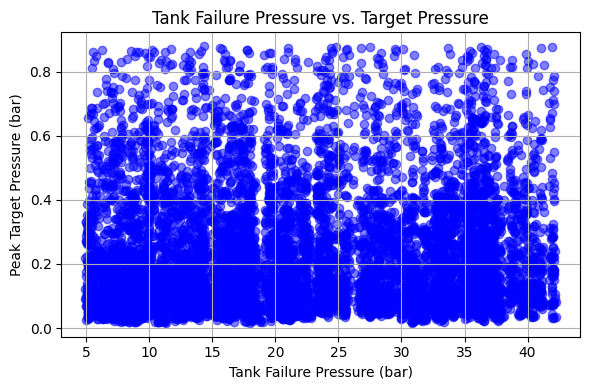

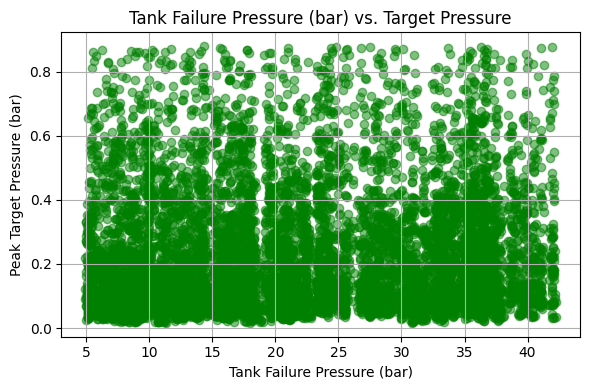

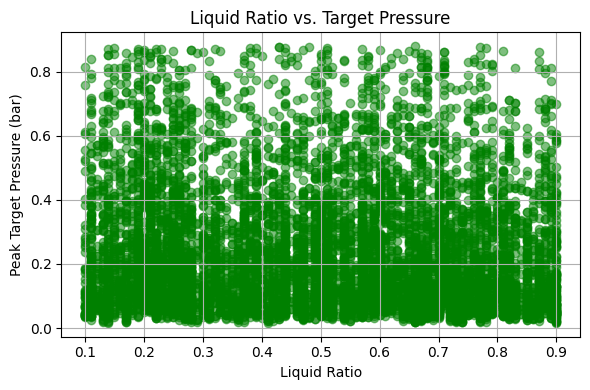

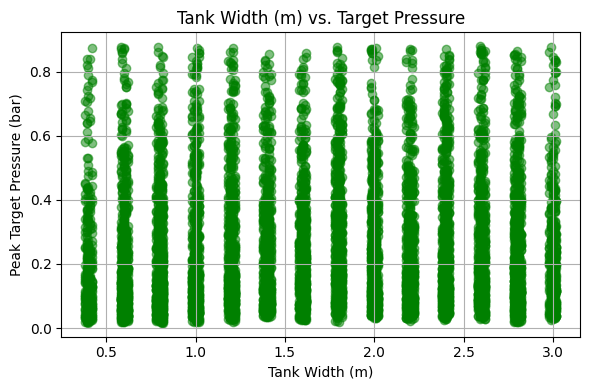

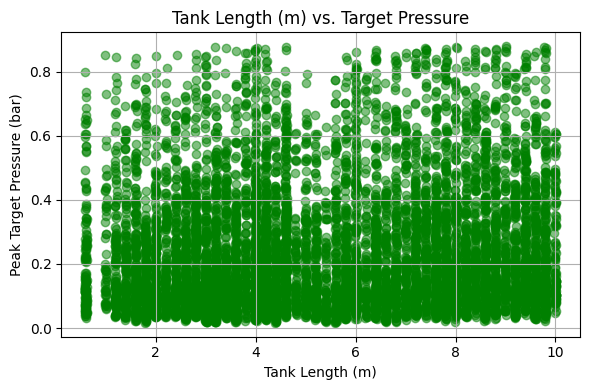

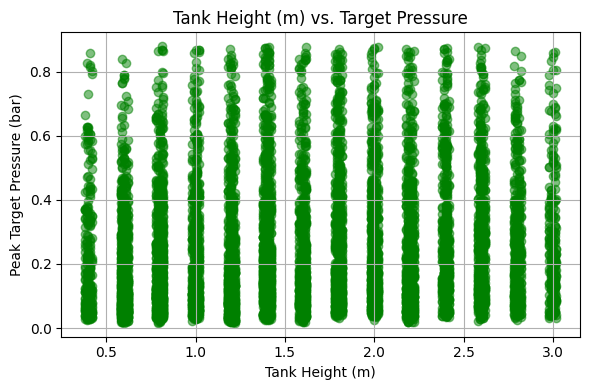

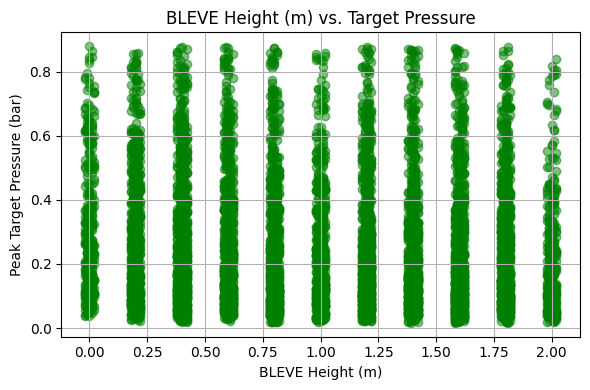

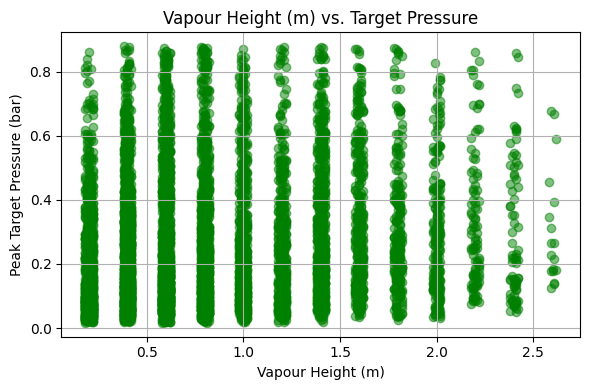

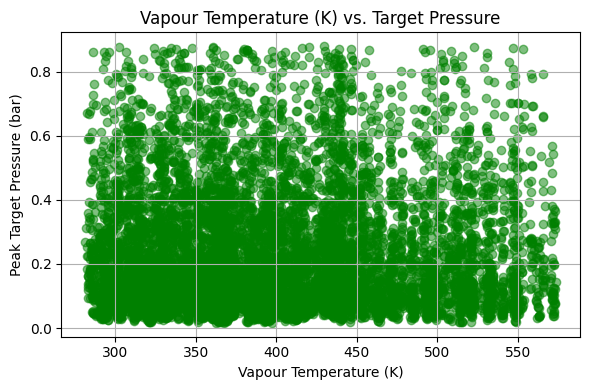

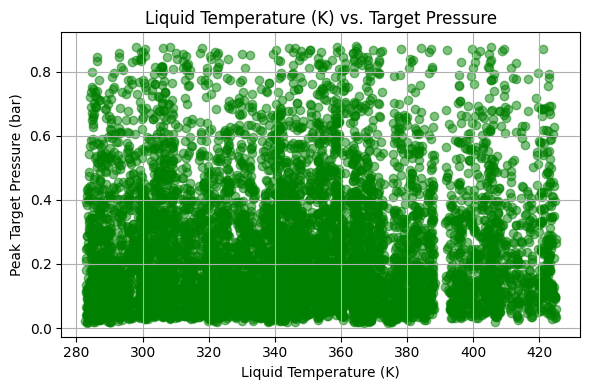

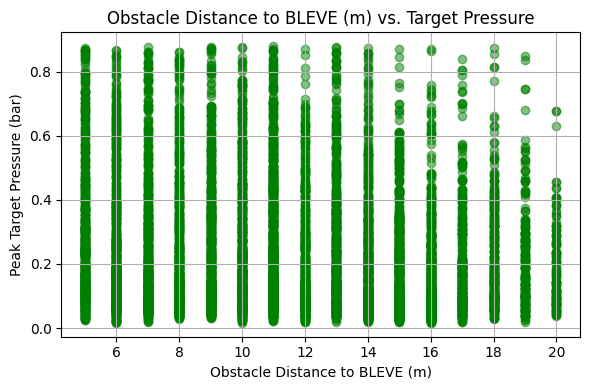

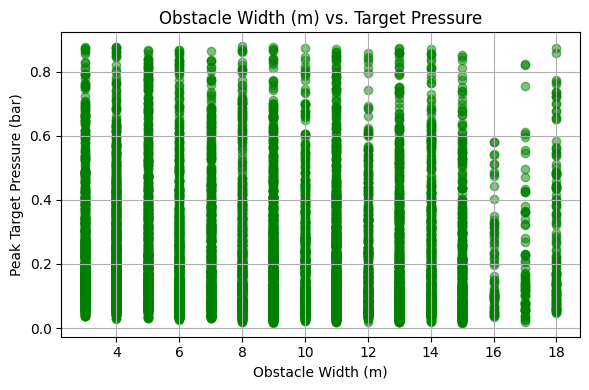

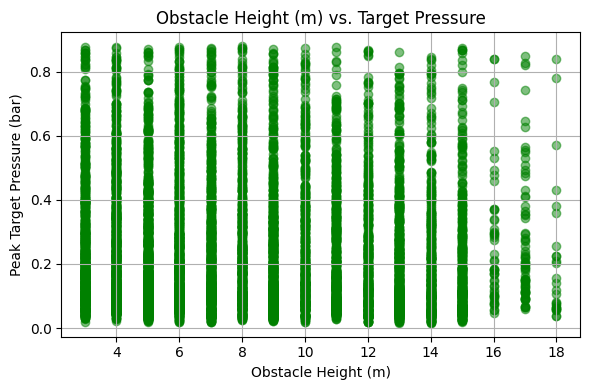

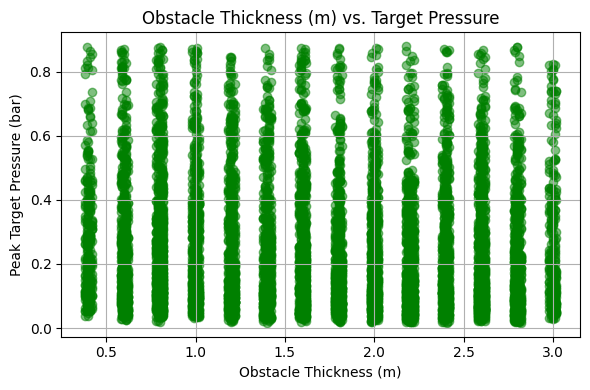

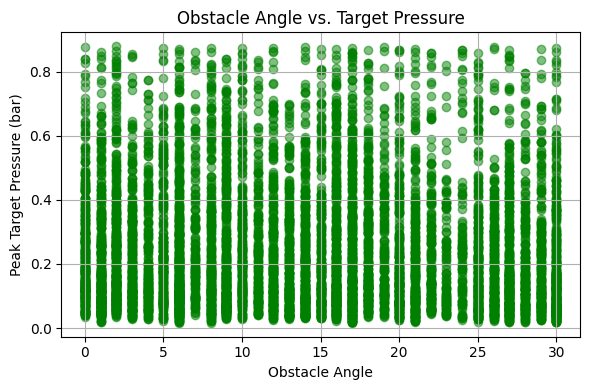

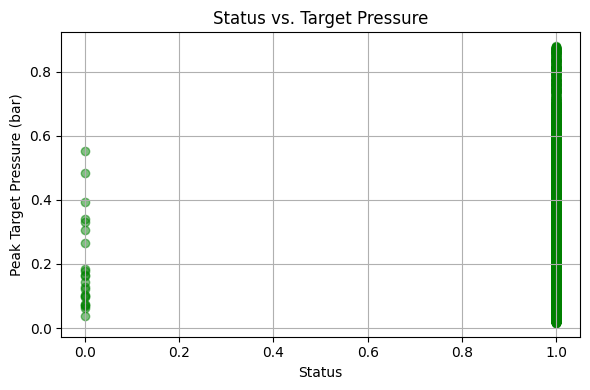

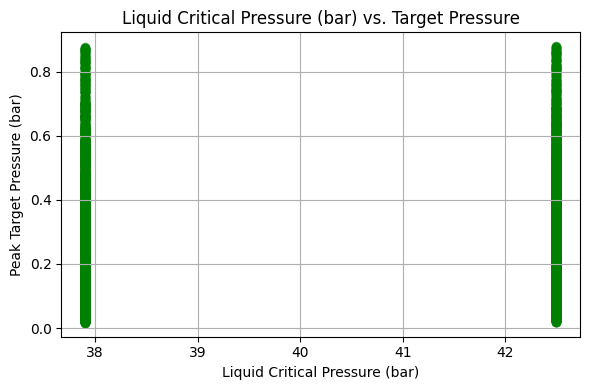

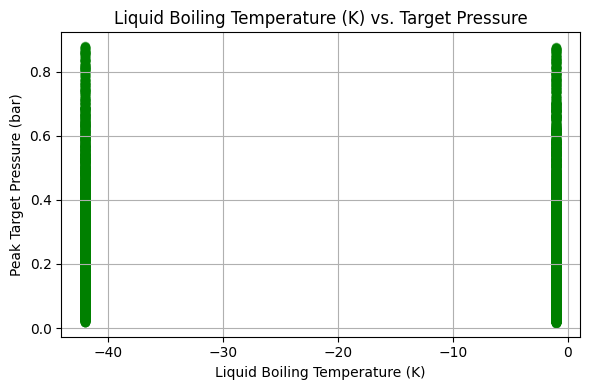

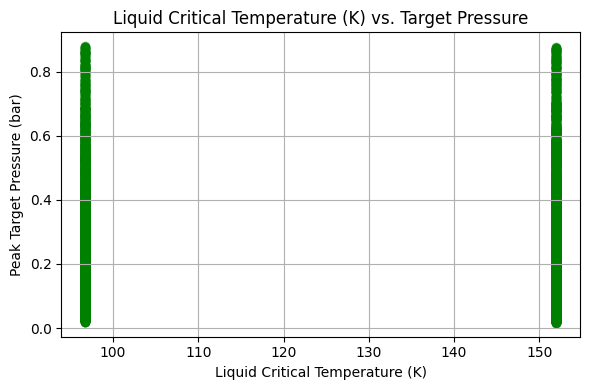

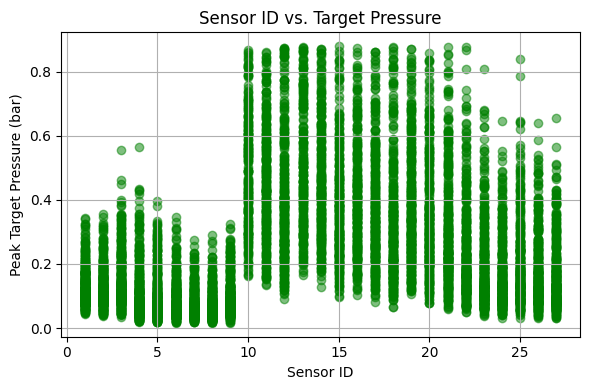

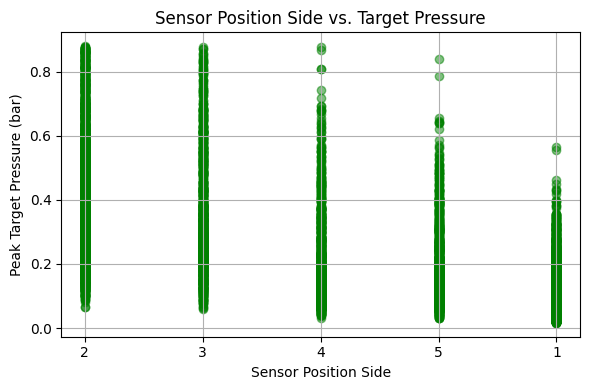

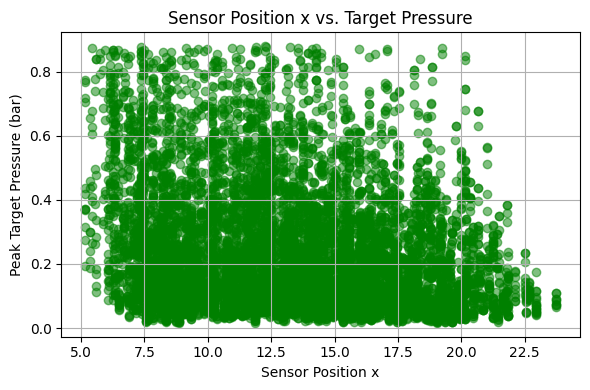

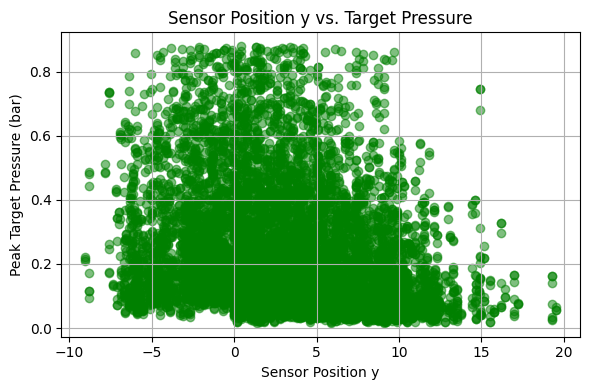

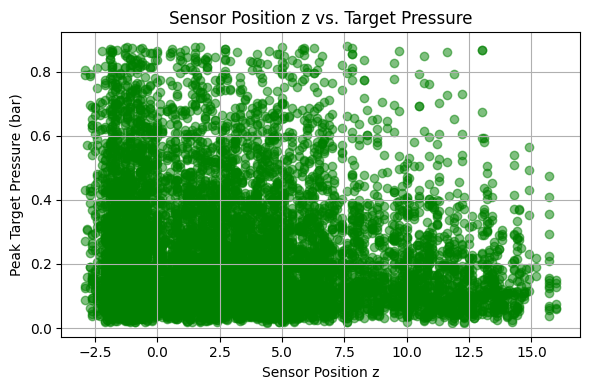

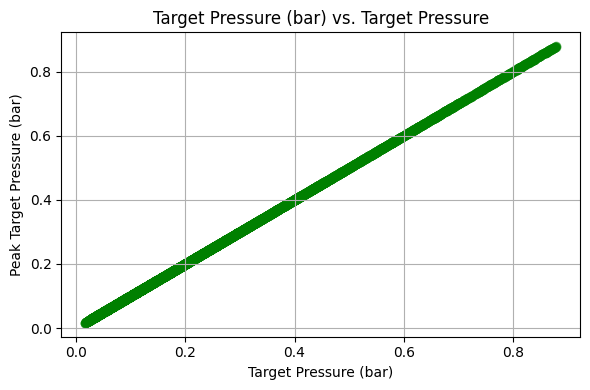

Total rows: 8993


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(pandas_df["Tank Failure Pressure (bar)"], pandas_df["Target Pressure (bar)"], alpha=0.5, color='blue')
plt.title("Tank Failure Pressure vs. Target Pressure")
plt.xlabel("Tank Failure Pressure (bar)")
plt.ylabel("Peak Target Pressure (bar)")
plt.grid(True)
plt.tight_layout()
plt.show()
features_to_plot = [
    "Tank Failure Pressure (bar)",
    "Liquid Ratio",
    "Tank Width (m)",
    "Tank Length (m)",
    "Tank Height (m)",
    "BLEVE Height (m)",
    "Vapour Height (m)",
    "Vapour Temperature (K)",
    "Liquid Temperature (K)",
    "Obstacle Distance to BLEVE (m)",
    "Obstacle Width (m)",
    "Obstacle Height (m)",
    "Obstacle Thickness (m)",
    "Obstacle Angle",
    "Status",
    "Liquid Critical Pressure (bar)",
    "Liquid Boiling Temperature (K)",
    "Liquid Critical Temperature (K)",
    "Sensor ID",
    "Sensor Position Side",
    "Sensor Position x",
    "Sensor Position y",
    "Sensor Position z",
    "Target Pressure (bar)"
]
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    plt.scatter(pandas_df[feature], pandas_df["Target Pressure (bar)"], alpha=0.5, color='green')
    plt.title(f"{feature} vs. Target Pressure")
    plt.xlabel(feature)
    plt.ylabel("Peak Target Pressure (bar)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
print("Total rows:", len(pandas_df))

Function for Visualization after each Model Training

In [ ]:
## CHATGPT Suggestion, modified to match the data requirements
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

def visualize_model(model, X_train, y_train, X_val, y_val, name):
    # Predict
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics on training
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    # Metrics on validation
    val_r2 = r2_score(y_val, y_val_pred)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

    # Print metrics
    print(f"\n{name} Evaluation:")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Training MAPE: {train_mape:.4f}")
    print(f"Validation R²: {val_r2:.4f}")
    print(f"Validation MAPE: {val_mape:.4f}")

    # Visualization
    # 1. Bar chart of metrics
    metrics = ['Train R²', 'Val R²', 'Train MAPE', 'Val MAPE']
    scores = [train_r2, val_r2, train_mape, val_mape]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(metrics, scores, color=['blue', 'skyblue', 'orange', 'gold'])
    plt.title(f"{name} - Model Performance Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)  # Set limit for better comparison
    plt.tight_layout()
    plt.show()

    # 2. Actual vs Predicted scatter plot (Validation)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5, color='green')
    plt.plot([np.min(y_val), np.max(y_val)], [np.min(y_val), np.max(y_val)], color='red', linestyle='--')
    plt.title(f"{name} - Validation: Actual vs Predicted")
    plt.xlabel("Actual Peak Pressure")
    plt.ylabel("Predicted Peak Pressure")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Residuals plot (Validation)
    residuals = y_val - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{name} - Validation: Residual Plot")
    plt.xlabel("Predicted Peak Pressure")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

##**3.2.2:** Data Preparation

In [ ]:
##CHATGPT Suggestion: Flatten Sensor_Side_Encoded (vector) into multiple columns
# Expand 'Sensor_Side_Encoded' vector column into multiple columns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
print(pandas_df.columns.tolist())
#Expand the One-Hot Encoded Vector (Sensor_Side_Encoded)
sensor_side_encoded_df = pandas_df["Sensor_Side_Encoded"].apply(pd.Series)

sensor_side_encoded_df = pandas_df["Sensor_Side_Encoded"].apply(lambda x: pd.Series(x.toArray())) #
sensor_side_encoded_df.columns = [f"sensor_side_encoded_{i}" for i in range(sensor_side_encoded_df.shape[1])] #

# Rename the new columns
sensor_side_encoded_df.columns = [f"sensor_side_encoded_{i}" for i in range(sensor_side_encoded_df.shape[1])]

# Concatenate with original DataFrame
pandas_df = pd.concat([pandas_df.drop(columns=["Sensor_Side_Encoded"]), sensor_side_encoded_df], axis=1)

# Column selection for data preparation
feature_cols = [
    "Tank Failure Pressure (bar)",
    "Liquid Ratio",
    "BLEVE Height (m)",
    "Vapour Height (m)",
    "Status",
    "Vapour Temperature (K)",
    "Liquid Temperature (K)",
    "Obstacle Distance to BLEVE (m)",
    "Obstacle Angle",
    "Sensor Position x",
    "Sensor Position y",
    "Sensor Position z",
    "Liquid Critical Pressure (bar)",
    "Liquid Boiling Temperature (K)",
    "Liquid Critical Temperature (K)",
    "Tank Volume (m^3)",
    "Tank Width (m)",
    "Tank Length (m)",
    "Tank Height (m)",
    "Obstacle Volume (m^3)",
    "Obstacle Width (m)",
    "Obstacle Height (m)",
    "Obstacle Thickness (m)",
    "Obstacle_Width_Distance_Ratio",
    "Obstacle_Height_Distance_Ratio",
    "Obstacle_Thickness_Distance_Ratio",
    "sensor_pos_x_norm",
    "sensor_pos_y_norm",
    "sensor_pos_z_norm",
    "BLEVE Height Normalisation",
    "Obstacle Distance Normalisation",
    "Energy",
    "Energy_Density",
    "Energy_Per_Unit_Distance",
    "Vapour_To_Liquid_Ratio",
    "Vapour_Criticality_Indicator"
] + list(sensor_side_encoded_df.columns)  #CHATGPT for this cluster of columns

X = pandas_df[feature_cols].values
y = pandas_df["Target Pressure (bar)"].values

#Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Training: ", X_train_scaled.shape, y_train.shape)
print("Validation: ", X_val_scaled.shape, y_val.shape)

['Tank Failure Pressure (bar)', 'Liquid Ratio', 'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)', 'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)', 'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)', 'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)', 'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)', 'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)', 'Sensor ID', 'Sensor Position x', 'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)', 'Tank Volume (m^3)', 'Obstacle Volume (m^3)', 'Sensor_Side_Index', 'Obstacle_Height_Distance_Ratio', 'Obstacle_Width_Distance_Ratio', 'Obstacle_Thickness_Distance_Ratio', 'sensor_pos_x_norm', 'sensor_pos_y_norm', 'sensor_pos_z_norm', 'BLEVE Height Normalisation', 'Obstacle Distance Normalisation', 'Energy', 'Energy_Density', 'Energy_Per_Unit_Distance', 'Vapour_To_Liquid_Ratio', 'Vapour_Criticality_Indicator', 'Sensor Position Side', 'Sensor_Side_Encoded']
Traini

## **3.2.3:** Model Training: Linear Regression

The linear regression model provides a decent baseline, capturing the general trend of peak pressures at lower ranges. However, the residual plot indicates increasing error variance with higher predicted values. This suggests that the linear model struggles to accurately capture the non-linear dynamics present at higher BLEVE pressures, likely due to complex interactions between features such as tank dimensions, liquid ratio, and obstacle proximity.

Consequently, using non-linear models like SVR or Random Forest Regressor is focused to better handle these complex relationships and reduce prediction errors in high-pressure scenarios.

In [ ]:
# Showing type for X_train and y_train (expect numpy.ndarray)
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>



Linear Regression Evaluation:
Training R²: 0.7258
Training MAPE: 0.4870
Validation R²: 0.7265
Validation MAPE: 0.4794


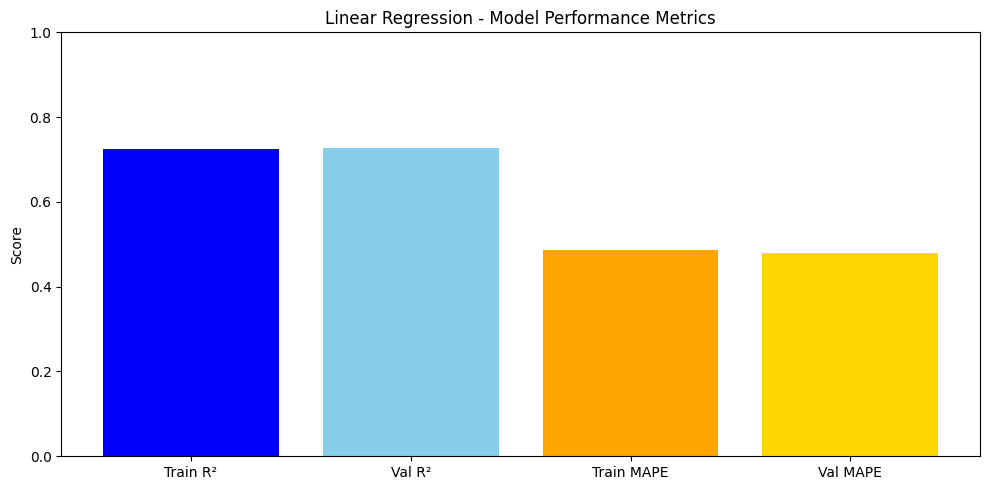

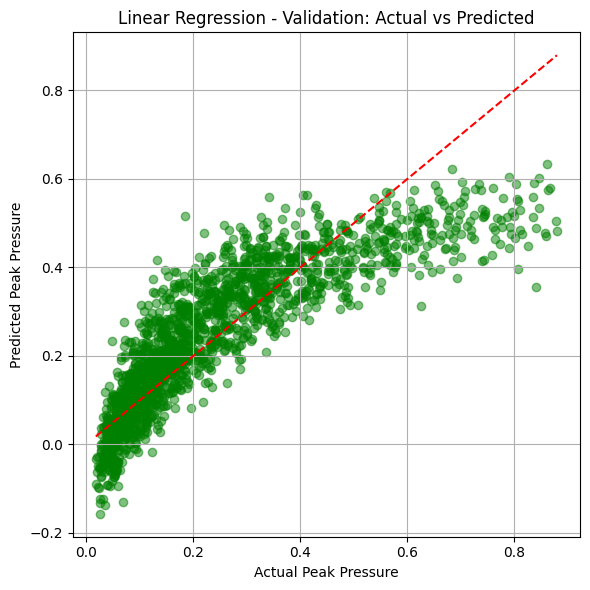

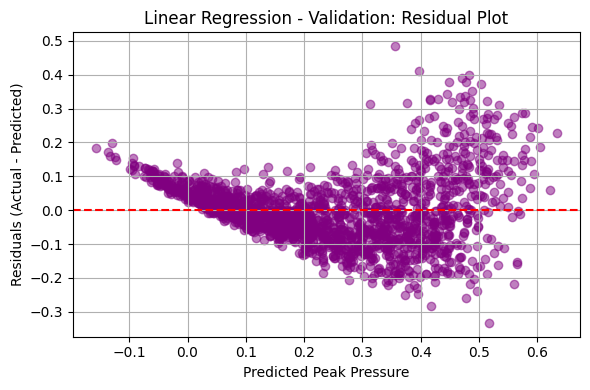

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

# Linear Regression training on scaled data
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

#Make prediction on validation
y_pred = lr.predict(X_val_scaled)

# Visualization
visualize_model(lr, X_train_scaled, y_train, X_val_scaled, y_val, "Linear Regression")

## **3.2.4:** Model Training: SVR with Random Search

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'kernel': 'rbf', 'gamma': 0.005, 'epsilon': 0.005, 'C': 100}

SVR - Tuned with RandomizedSearchCV Evaluation:
Training R²: 0.9617
Training MAPE: 0.0988
Validation R²: 0.9374
Validation MAPE: 0.1566


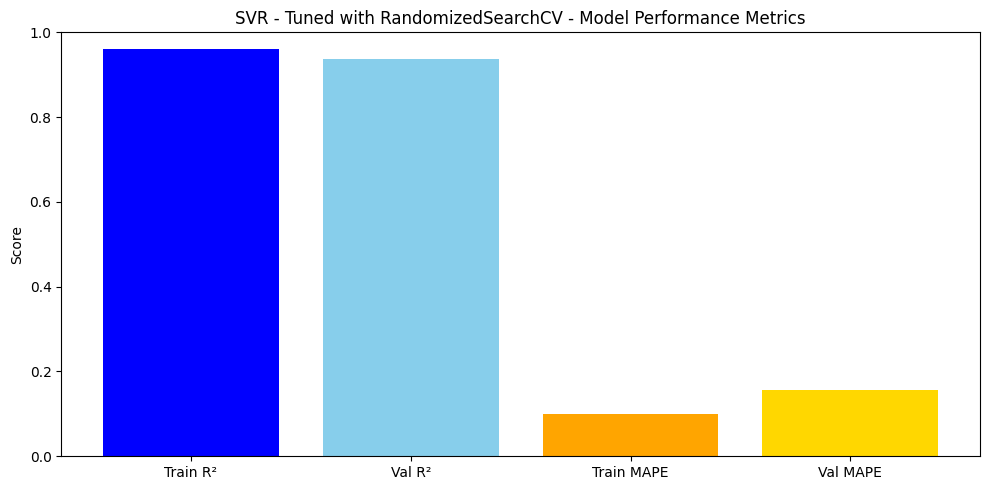

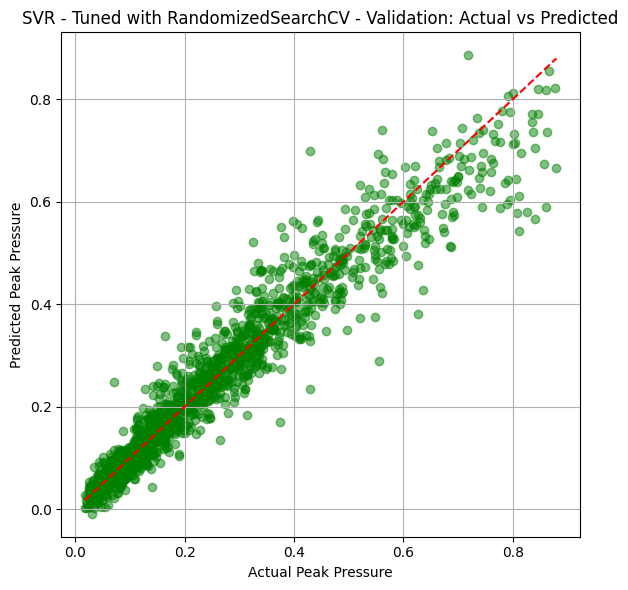

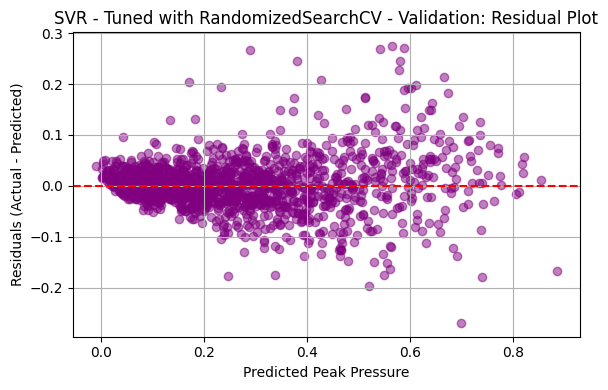

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import uniform
import numpy as np

param_dist = {
    'C': [100, 200, 300],
    'epsilon': [0.005, 0.01],
    'gamma': [0.005, 0.01],
    'kernel': ['rbf']
}
svr = SVR()

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)
#Fit model
random_search.fit(X_train_scaled, y_train)
best_svr = random_search.best_estimator_

print("Best parameters found:", random_search.best_params_)
y_pred = best_svr.predict(X_val_scaled)
visualize_model(best_svr, X_train_scaled, y_train, X_val_scaled, y_val, "SVR - Tuned with RandomizedSearchCV")

## **Section 3.2.5:** Model Training: Random Forest with Grid Search tuning

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Random Forest Evaluation:
Training R²: 0.9852
Training MAPE: 0.0724
Validation R²: 0.8850
Validation MAPE: 0.1897


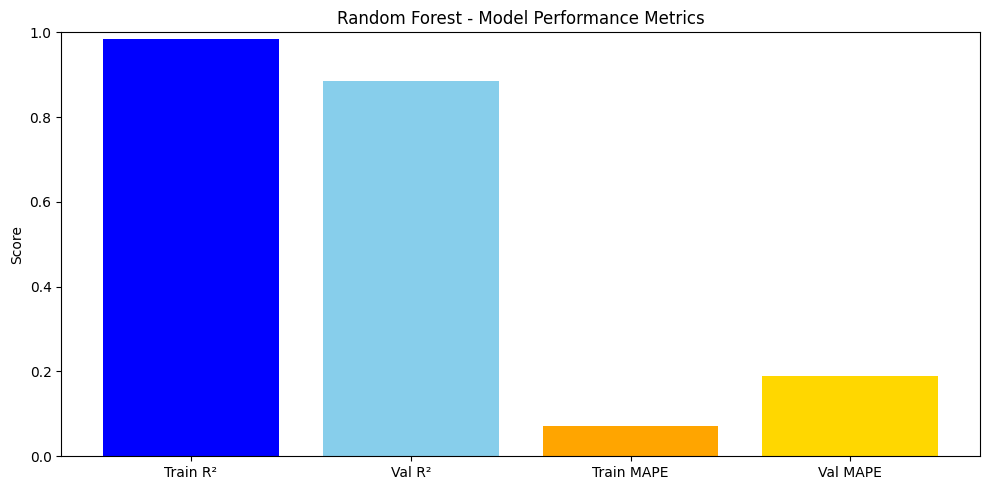

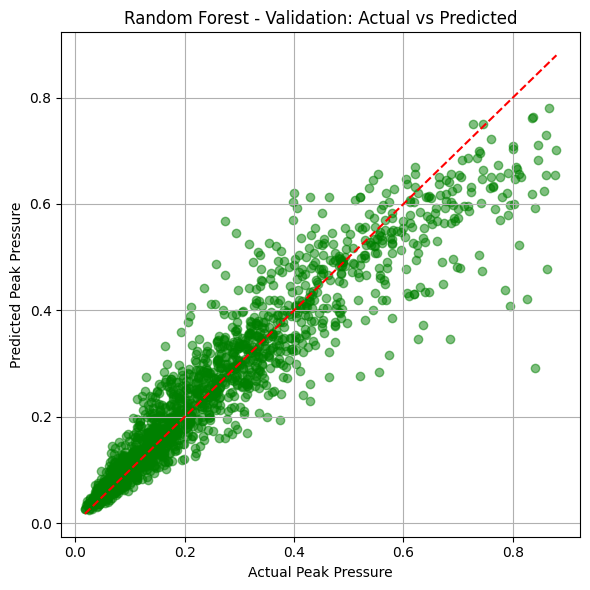

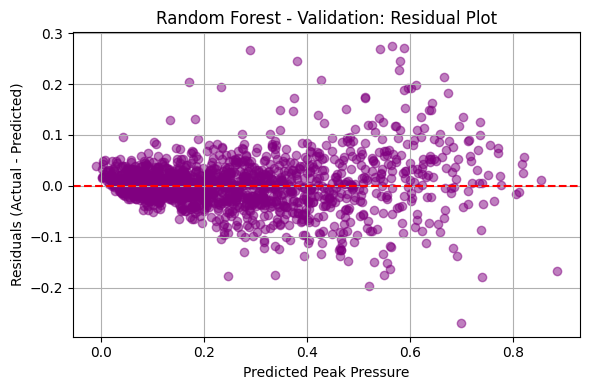

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Hyperparam Tuning: Grid Search
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']

}
rf = RandomForestRegressor(random_state=42)
gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
gs.fit(X_train_scaled, y_train)

# Training
rf.fit(X_train_scaled, y_train)
best_rf = gs.best_estimator_
print("Best parameters found:", gs.best_params_)

# Visualize output
visualize_model(rf, X_train_scaled, y_train, X_val_scaled, y_val, "Random Forest")

## **Section 3.2.6:** Model: Training: Essembling (SVR and RF)

Define a threshold to split the prediction zone for SVR and RF as each model is stronger at a different zone.


SVR + RF Ensemble (Dynamic Weighting) Evaluation:
Training R²: 0.9675
Training MAPE: 0.0846
Validation R²: 0.9385
Validation MAPE: 0.1472


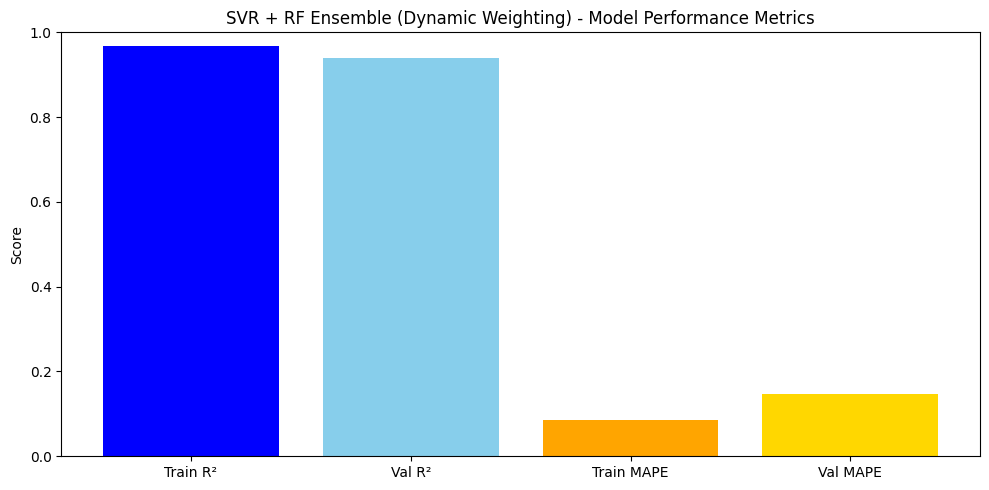

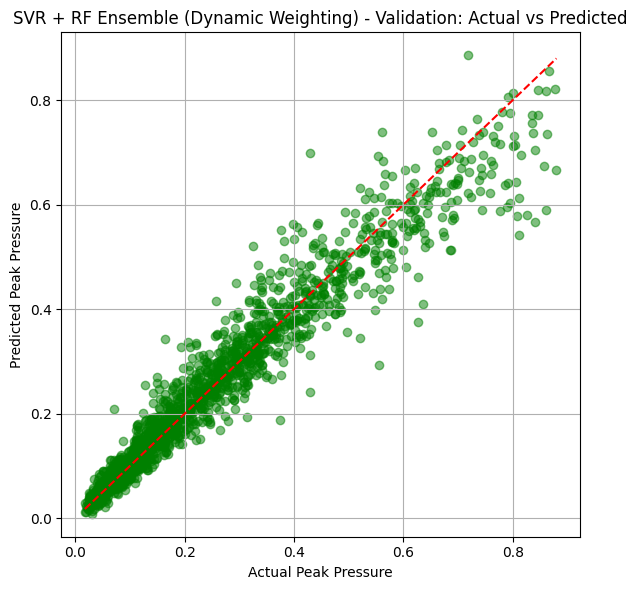

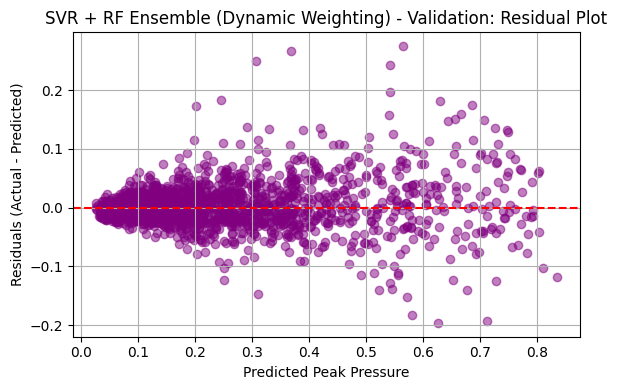

In [ ]:
#Ensemble with weight distribution
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
# Predict from both models
svr_preds = best_svr.predict(X_val_scaled)
rf_preds = best_rf.predict(X_val_scaled)

threshold = 0.5

#ensemble_preds = np.where(
#    y_val <= threshold,
#    0.3 * rf_preds + 0.7 * svr_preds,  # low range
#    0 * rf_preds + 1 * svr_preds   # high range
#)

class EnsembleModel(BaseEstimator, RegressorMixin):
    def __init__(self, svr_model, rf_model, threshold=0.5):
        self.svr_model = svr_model
        self.rf_model = rf_model
        self.threshold = threshold

    def fit(self, X, y):
        return self

    def predict(self, X):
        svr_preds = self.svr_model.predict(X)
        rf_preds = self.rf_model.predict(X)
        return np.where(
            svr_preds <= self.threshold,  # Use svr_preds for thresholding
            0.3 * rf_preds + 0.7 * svr_preds,
            0 * rf_preds + 1 * svr_preds
        )

# Create an instance of the EnsembleModel with the trained SVR and RF models
ensemble_model = EnsembleModel(best_svr, best_rf, threshold=threshold)

# Visualize (call predict on training and validation data)
visualize_model(ensemble_model, X_train_scaled, y_train, X_val_scaled, y_val, "SVR + RF Ensemble (Dynamic Weighting)")

## **Section 3.2.7**: XGBoost with Grid Search



Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}

Tuned XGBoost Evaluation:
Training R²: 0.9987
Training MAPE: 0.0352
Validation R²: 0.9336
Validation MAPE: 0.1415


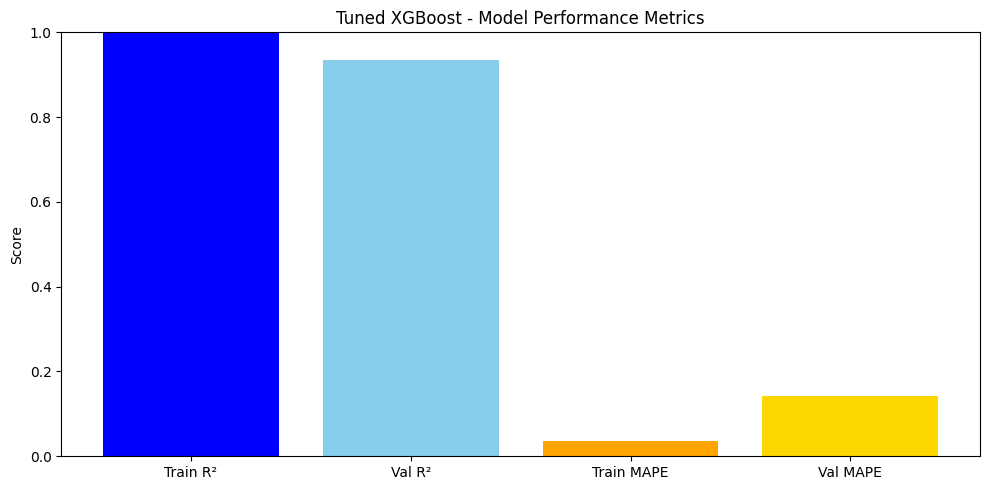

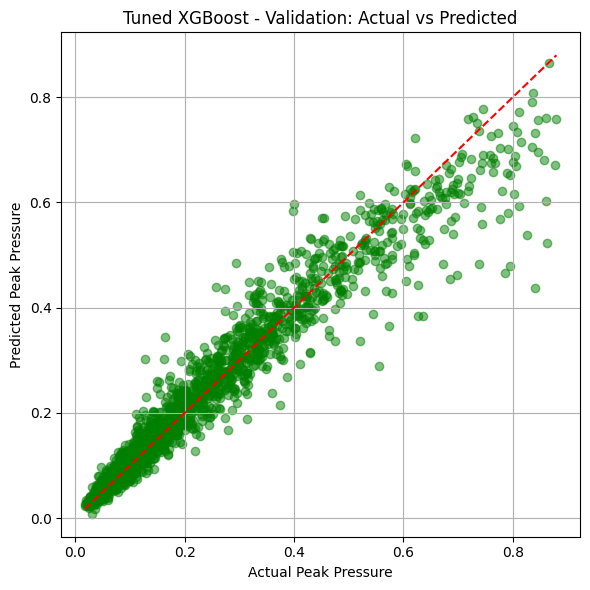

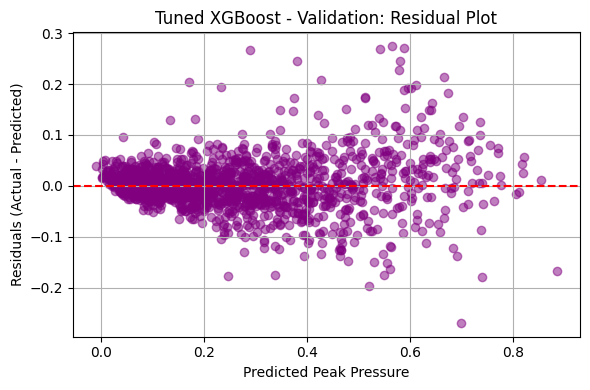

In [ ]:
# CHATGPT suggestion for configuration of grid. This was then manually modified to improve performance
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

xgb = XGBRegressor(random_state=42)

# Strategy
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
# Training
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

# Predict & visualize
visualize_model(best_model, X_train_scaled, y_train, X_val_scaled, y_val, "Tuned XGBoost")

## Section 3.2.8: Neural Network

Use Leaky ReLU instead of ReLU

In [ ]:
# CHATGPT suggestion for configuration
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import numpy as np
from tensorflow.keras.layers import LeakyReLU

# Define the model
def build_tuned_model(input_dim):
    model = Sequential()

    model.add(Dense(512, input_shape=(input_dim,)))
    model.add(LeakyReLU(negative_slope=0.01))  # Instead of activation='relu'
    model.add(BatchNormalization())  # To prevent overfitting
    model.add(Dropout(0.4))

    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())  # To prevent overfitting
    model.add(Dropout(0.4))

    model.add(Dense(128))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization()) # To prevent overfitting

    model.add(Dense(64))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dense(1))  # Output layer for regression

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae', metrics=['mae', 'mape'])
    return model

# Build the model
input_dim = X_train_scaled.shape[1]
nn_model = build_tuned_model(input_dim)

# Stop if val not improve after 50 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict and evaluate
y_pred = nn_model.predict(X_val_scaled).flatten()
y_train_pred = nn_model.predict(X_train_scaled).flatten()

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

# Display output results
print(f"\nTuned Neural Network Evaluation:")
print(f"Validation R²: {r2:.4f}")
print(f"Validation MAPE: {mape:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Training MAPE: {train_mape:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6677 - mae: 0.6677 - mape: 557.4569 - val_loss: 0.2014 - val_mae: 0.2014 - val_mape: 176.6219
Epoch 2/250
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3802 - mae: 0.3802 - mape: 304.4492 - val_loss: 0.1949 - val_mae: 0.1949 - val_mape: 155.9724
Epoch 3/250
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3087 - mae: 0.3087 - mape: 244.8465 - val_loss: 0.1544 - val_mae: 0.1544 - val_mape: 119.8647
Epoch 4/250
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2383 - mae: 0.2383 - mape: 190.9345 - val_loss: 0.1371 - val_mae: 0.1371 - val_mape: 97.1670
Epoch 5/250
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1919 - mae: 0.1919 - mape: 143.3626 - val_loss: 0.0971 - val_mae: 0.0971 - val_mape: 65.5325
Epoch 6/250
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1469 - mae: 0.1469 - mape: 110.9913 - val_loss: 0.0784 - val_mae: 0.0784 - val_mape: 52.5649
Epoch 7/250
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss

## Section 3.2.9: Tuned Neural Network (Leaky ReLU)

In [ ]:
!pip install keras-tuner --upgrade
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import keras_tuner as kt  # or from kerastuner import RandomSearch (for older versions)

input_dim = X_train_scaled.shape[1]

# Define model builder for Keras Tuner
def build_model(hp):
    model = Sequential()

    #Tuning Negative Slope for leakyReLU
    slope = hp.Float('slope', min_value=0.01, max_value=0.3, step=0.02)
    # First hidden layer
    model.add(Dense(units=hp.Int('units_input', min_value=256, max_value=1024, step=128), input_shape=(input_dim,)))
    model.add(LeakyReLU(negative_slope=slope))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_input', min_value=0.2, max_value=0.6, step=0.1)))

    # Second hidden layer
    model.add(Dense(units=hp.Int('units_hidden', min_value=128, max_value=512, step=64)))
    model.add(LeakyReLU(negative_slope=slope))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_hidden', min_value=0.2, max_value=0.6, step=0.1)))

    model.add(Dense(hp.Int('units_third', min_value=64, max_value=256, step=64)))
    model.add(LeakyReLU(negative_slope=slope))
    model.add(Dropout(hp.Float('dropout_third', min_value=0.2, max_value=0.6, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='LOG')),
        loss='mae',
        metrics=['mae', 'mape']
    )
    return model

# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=4,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='regression_model_tuning'
)

# Summary of search space
tuner.search_space_summary()

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Strategy
tuner.search(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate
y_val_pred = best_model.predict(X_val_scaled).flatten()
y_train_pred = best_model.predict(X_train_scaled).flatten()

# Metrics
print("\nTuned Neural Network Evaluation:")
print(f"Validation R²: {r2_score(y_val, y_val_pred):.4f}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}")
print(f"Training R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Training MAPE: {mean_absolute_percentage_error(y_train, y_train_pred):.4f}")

# print best hyperparameters
print("\nBest Hyperparameters:")
print(tuner.get_best_hyperparameters(1)[0].values)

Trial 4 Complete [00h 07m 35s]
val_loss: 0.09875447303056717

Best val_loss So Far: 0.03257500007748604
Total elapsed time: 00h 38m 14s
 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Tuned Neural Network Evaluation:
Validation R²: 0.9269
Validation MAPE: 0.1565
Training R²: 0.9523
Training MAPE: 0.1311

Best Hyperparameters:
{'units_input': 256, 'dropout_input': 0.2, 'units_hidden': 320, 'dropout_hidden': 0.30000000000000004, 'use_third_layer': True, 'learning_rate': 0.0003481939845832107, 'units_third': 64, 'slope': 0.01}


# Section 3.3: Testing

## Loading test.csv and data processing
  

This section is required as the schema of test.csv is not identical to train.csv due to Feature Engineering, Feature Scaling, Categorizing and Indexing. Thus, data transformation for test.csv is neccessary.

In [ ]:
print(X_train.shape, X_test.shape)


(7437, 39) (3203, 36)


In [ ]:
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#Load
test_df = spark.read.csv("test.csv", header=True, inferSchema=True)
#Feature Engineering
test_df = test_df.withColumn("Tank Volume (m^3)", (col("Tank Width (m)") * col("Tank Length (m)") * col("Tank Height (m)")).cast("double"))
test_df = test_df.withColumn("Obstacle Volume (m^3)", (col("Obstacle Width (m)") * col("Obstacle Height (m)") * col("Obstacle Thickness (m)")).cast("double"))
epsilon = 1e-5
test_df = test_df.withColumn("Obstacle_Height_Distance_Ratio", col("Obstacle Height (m)") / (col("Obstacle Distance to BLEVE (m)") + epsilon))
test_df = test_df.withColumn("Obstacle_Width_Distance_Ratio", col("Obstacle Width (m)") / (col("Obstacle Distance to BLEVE (m)") + epsilon))
test_df = test_df.withColumn("Obstacle_Thickness_Distance_Ratio", col("Obstacle Thickness (m)") / (col("Obstacle Distance to BLEVE (m)") + epsilon))
test_df = test_df.withColumn("sensor_pos_x_norm", col("Sensor Position x") / (col("Tank Width (m)") + epsilon))
test_df = test_df.withColumn("sensor_pos_y_norm", col("Sensor Position y") / (col("Tank Height (m)") + epsilon))
test_df = test_df.withColumn("sensor_pos_z_norm", col("Sensor Position z") / (col("Tank Length (m)") + epsilon))
#New col
test_df = test_df.withColumn("Energy", col("Tank Volume (m^3)") * col("Liquid Ratio") * col("Vapour Temperature (K)"))
test_df = test_df.withColumn("Energy_Density", col("Energy") / (col("Tank Volume (m^3)") + epsilon))
test_df = test_df.withColumn("Energy_Per_Unit_Distance", col("Energy") / (col("Obstacle Distance to BLEVE (m)") + epsilon))
test_df = test_df.withColumn("Vapour_To_Liquid_Ratio", col("Vapour Temperature (K)") / (col("Liquid Temperature (K)") + epsilon))
test_df = test_df.withColumn("Vapour_Criticality_Indicator", col("Vapour Temperature (K)") - col("Liquid Critical Temperature (K)"))
# Height normalisation
test_df = test_df.withColumn("BLEVE Height Normalisation", col("BLEVE Height (m)") / (col("Tank Height (m)") + epsilon))
#Obstacle Distance Normalisation
test_df = test_df.withColumn("Obstacle Distance Normalisation", col("Obstacle Distance to BLEVE (m)") / (col("Tank Height (m)") + epsilon))

#Indexing & Categorizing
test_df = test_df.withColumn("Status", when(col("Status") == "subcooled", 0).otherwise(1))
test_df = test_df.withColumn("Sensor Position Side", col("Sensor Position Side").cast("string"))
indexer = StringIndexer(inputCols=["Sensor Position Side"], outputCols=["Sensor_Side_Index"], handleInvalid="skip")
encoder = OneHotEncoder(inputCols=["Sensor_Side_Index"], outputCols=["Sensor_Side_Encoded"], dropLast=False)
test_df = indexer.fit(test_df).transform(test_df)
test_df = encoder.fit(test_df).transform(test_df)

#Convert to pandas
feature_and_target = test_df.select(
    "Tank Failure Pressure (bar)",
    "Liquid Ratio",
    "Tank Width (m)",
    "Tank Length (m)",
    "Tank Height (m)",
    "BLEVE Height (m)",
    "Vapour Height (m)",
    "Vapour Temperature (K)",
    "Liquid Temperature (K)",
    "Obstacle Distance to BLEVE (m)",
    "Obstacle Width (m)",
    "Obstacle Height (m)",
    "Obstacle Thickness (m)",
    "Obstacle Angle",
    "Status",
    "Liquid Critical Pressure (bar)",
    "Liquid Boiling Temperature (K)",
    "Liquid Critical Temperature (K)",
    "Sensor ID",
    "Sensor Position Side",
    "Sensor Position x",
    "Sensor Position y",
    "Sensor Position z",
    "Tank Volume (m^3)",
    "Obstacle Volume (m^3)",
    "Sensor_Side_Index",
    "Sensor_Side_Encoded",
    "Obstacle_Height_Distance_Ratio",
    "Obstacle_Width_Distance_Ratio",
    "Obstacle_Thickness_Distance_Ratio",
    "sensor_pos_x_norm",
    "sensor_pos_y_norm",
    "sensor_pos_z_norm",
    "BLEVE Height Normalisation",
    "Obstacle Distance Normalisation",
    "Energy",
    "Energy_Density",
    "Energy_Per_Unit_Distance",
    "Vapour_To_Liquid_Ratio",
    "Vapour_Criticality_Indicator"
)
test_pandas_df = feature_and_target.toPandas()
print(test_pandas_df.isnull().sum())


# Expand Sensor_Side_Encoded vector into separate columns
sensor_side_encoded_df = test_pandas_df["Sensor_Side_Encoded"].apply(lambda x: pd.Series(x.toArray()))
sensor_side_encoded_df.columns = [f"sensor_side_encoded_{i}" for i in range(sensor_side_encoded_df.shape[1])]

# Concatenate with original DataFrame
test_pandas_df = pd.concat([test_pandas_df.drop(columns=["Sensor_Side_Encoded"]), sensor_side_encoded_df], axis=1)

feature_cols = [
    "Tank Failure Pressure (bar)",
    "Liquid Ratio",
    "BLEVE Height (m)",
    "Vapour Height (m)",
    "Status",
    "Vapour Temperature (K)",
    "Liquid Temperature (K)",
    "Obstacle Distance to BLEVE (m)",
    "Obstacle Angle",
    "Sensor Position x",
    "Sensor Position y",
    "Sensor Position z",
    "Liquid Critical Pressure (bar)",
    "Liquid Boiling Temperature (K)",
    "Liquid Critical Temperature (K)",
    "Tank Volume (m^3)",
    "Tank Width (m)",
    "Tank Length (m)",
    "Tank Height (m)",
    "Obstacle Volume (m^3)",
    "Obstacle Width (m)",
    "Obstacle Height (m)",
    "Obstacle Thickness (m)",
    "Obstacle_Width_Distance_Ratio",
    "Obstacle_Height_Distance_Ratio",
    "Obstacle_Thickness_Distance_Ratio",
    "sensor_pos_x_norm",
    "sensor_pos_y_norm",
    "sensor_pos_z_norm",
    "BLEVE Height Normalisation",
    "Obstacle Distance Normalisation",
    "Energy",
    "Energy_Density",
    "Energy_Per_Unit_Distance",
    "Vapour_To_Liquid_Ratio",
    "Vapour_Criticality_Indicator"
] + list(sensor_side_encoded_df.columns)

# Prepare features for prediction (use same feature_cols from training)
X_test = test_pandas_df[feature_cols].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Random Forest
#best_rf = gs.best_estimator_
#test_predictions = best_rf.predict(X_test_scaled)

# SVR
#best_svr_model = best_svr.best_estimator_
#test_predictions = best_svr.predict(X_test_scaled)

#Esemble
#svr_test_preds = best_svr.predict(X_test_scaled)
#rf_test_preds = best_rf.predict(X_test_scaled)
#threshold = 0.5
#test_predictions = np.where(
#    svr_test_preds <= threshold,
#    0.3 * rf_test_preds + 0.7 * svr_test_preds,
#    0 * rf_test_preds + 1 * svr_test_preds
#)

#XGBoost
#test_predictions = xgb_model.predict(X_test_scaled)

#XGBoost with Tuning
#best_xgb = grid_search.best_estimator_
#test_predictions = best_xgb.predict(X_test_scaled)

##NN
test_predictions = nn_model.predict(X_test_scaled).flatten()

# submission file
submission = pd.DataFrame({
    "Target Pressure (bar)": test_predictions
})
submission.insert(0, "ID", range(len(submission)))
submission.to_csv("submission.csv", index=False)
print("Final submission.csv created")

Tank Failure Pressure (bar)          0
Liquid Ratio                         0
Tank Width (m)                       0
Tank Length (m)                      0
Tank Height (m)                      0
BLEVE Height (m)                     0
Vapour Height (m)                    0
Vapour Temperature (K)               0
Liquid Temperature (K)               0
Obstacle Distance to BLEVE (m)       0
Obstacle Width (m)                   0
Obstacle Height (m)                  0
Obstacle Thickness (m)               0
Obstacle Angle                       0
Status                               0
Liquid Critical Pressure (bar)       0
Liquid Boiling Temperature (K)       0
Liquid Critical Temperature (K)      0
Sensor ID                            0
Sensor Position Side                 0
Sensor Position x                    0
Sensor Position y                    0
Sensor Position z                    0
Tank Volume (m^3)                    0
Obstacle Volume (m^3)                0
Sensor_Side_Index        